In [67]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from side_by_side import print_side_by_side as pss
from pprint import pprint as pp
from pprint import pformat as pf
import pandas as pd
from functools import reduce
import math
import covid_utilities as cu

In [2]:
base_path = cu.DATA_PATH + r"\ABC_results"
template_path = base_path + r"\{0}\finalpopulation\posterior\{0}-modelprobabilities.csv"
fig_path = r"C:\Users\Konrad Grudzinski\OneDrive - University of Glasgow\Computing\4th Year\Individual Project\paper_files\plots\{}" # where figures go

---

Fractions

In [11]:
filtered = 0.001
Nmax = 2000
data = cu.get_all_probs(filtering = [0.01, 0.001, 0.0001], n_max = Nmax)

In [12]:
labels = [f"2020-{month:02}" for month in range(6,13)] + [f"2021-{month:02}" for month in range(1,13)] + ["2022-01", "2022-02"]
label_positions = {l:i for i,l in enumerate(labels)}

In [68]:
all_figures = cu.FigureContainer(plt)

In [14]:
case_counts = cu.load_json(cu.COVID_PATH + "\EUClusters_data.json")
cases = {key.replace(" ", "-"):values for key, values in case_counts["countries"].items()}

In [26]:
def plot_variant_fraction(country_freqs, ax, stacked = False, indices = None): # 15 EU1, 0 alpha, 5 delta, 6 omicron
    colors = ["fuchsia", "r", "darkblue"]
    mutations = [f"{i} subclones" for i in range(3)]
    variant_names = list(country_freqs[list(country_freqs.keys())[0]].keys())
    fractions = np.array(list(
        map(lambda x:np.array(list(x[1].values())), sorted(filter(lambda f: f[0] in labels, country_freqs.items()), key = lambda x:x[0]))
    ))
    x_f = np.array(sorted(map(lambda f:label_positions[f], filter(lambda f: f in labels, country_freqs.keys())))) + 1
    colors = [cu.variant_color_mapping[n] for n in variant_names if n in cu.variant_color_mapping]
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlim(0,len(labels)-1)
    
    if indices is None:
        indices = np.arange(fractions.shape[1])
    fractions = fractions[:, indices] 
    if not stacked:
        return [ax.plot(x_f, fractions.T[i], label=variant_names[indices[i]], color=colors[indices[i]])[0] for i in range(fractions.shape[1])]      
    else:
        return ax.stackplot(x_f,
                fractions.T,
                labels=variant_names,
                colors=colors,
                alpha=0.75)

In [31]:
def stack_and_line_plot(cases, data, countries, filtering, gaps = False, vertical_lines = False, stacked = True, save = True):
    n = len(countries)
    if n == 0:
        return
    fig, axes = plt.subplots(n, figsize=(25, 10*n))#, dpi=200)
    if n == 1:
        axes = [axes]
    all_figures.add(fig)
    handles = []
    for ci, country in enumerate(countries):
        ax = axes[ci]
        country_freqs = cu.get_freqs(cases, country)
        country_data = data[country]
        x,y = list(zip(*sorted(
            [
                (label_positions[date], values[filtering]) for date, values in country_data.items() if filtering in values and date in label_positions
            ], key=lambda x:x[0])))
        x = np.array(x)
        y = np.array(y)
        colors = ["fuchsia", "r", "darkblue"]
        mutations = [f"{i} subclones" for i in range(3)]

        if vertical_lines:
            for i in x:
                ax.axvline(i+0.5, color="gray", linestyle=["--", "-."][i%2], alpha=0.3)

        handles.append(plot_variant_fraction(country_freqs, ax, stacked))

        if gaps:
            y_new = np.full([len(labels), y.shape[1]], np.nan)
            x_new = np.full(len(labels), np.nan)
            for i, index in enumerate(x):
                y_new[index] = y[i]
                x_new[index] = index + 0.5
            handles.append([ax.plot(x_new, y_new[:,i], color=colors[i], label=mutations[i])[0] for i in range(3)])
            [ax.scatter(np.arange(len(labels))+0.5,y_new[:,i], color=colors[i], alpha=1) for i in range(3)]
        else:
            handles.append([ax.plot(x+0.5, y[:,i], color=colors[i], label=mutations[i])[0] for i in range(3)])
            [ax.scatter(x+0.5, y[:,i], color=colors[i], alpha=1) for i in range(3)]

        ax.set_title(f"{country.replace('-', ' ')}", fontsize = 30)
    fig.suptitle("Predicted model probabilities and actual variant fractions", fontsize = 35)
    handles = sorted(handles, key=lambda x:len(x))
    legend = fig.legend(handles = handles[-1] + handles[0], loc="upper left", bbox_to_anchor=(0, 0.96))
    for line in legend.get_lines():
        line.set_linewidth(8)
    fig.supxlabel("Date", fontsize = 25)
    fig.supylabel("Fraction of variant in total population (stacked) & predicted model probability (lines and dots)", fontsize = 25)
    fig.tight_layout(h_pad=2.8)
    fig.subplots_adjust(top=0.95, left=0.15)
    if save:
        fig.savefig(fig_path.format("probs_fractions.eps"))

In [20]:
def stack_and_line_plot_vary_filtering(cases, data, country, filtering, gaps = False, vertical_lines = False, stacked = True, save = True):
    n = len(filtering)
    if n == 0:
        return
    fig, axes = plt.subplots(1,n, figsize=(25, 12), sharey=True)#, dpi=200)
    if n == 1:
        axes = [axes]
    all_figures.add(fig)
    handles = []
    country_freqs = cu.get_freqs(cases, country)
    country_data = data[country]
    for ci, minVAF in enumerate(filtering):
        ax = axes[ci]
        x,y = list(zip(*sorted(
            [
                (label_positions[date], values[minVAF]) for date, values in country_data.items() if minVAF in values and date in label_positions
            ], key=lambda x:x[0])))
        x = np.array(x)
        y = np.array(y)
        colors = ["fuchsia", "r", "darkblue"]
        mutations = [f"{i} subclones" for i in range(3)]

        if vertical_lines:
            for i in x:
                ax.axvline(i+0.5, color="gray", linestyle=["--", "-."][i%2], alpha=0.3)

        handles.append(plot_variant_fraction(country_freqs, ax, stacked))

        if gaps:
            y_new = np.full([len(labels), y.shape[1]], np.nan)
            x_new = np.full(len(labels), np.nan)
            for i, index in enumerate(x):
                y_new[index] = y[i]
                x_new[index] = index + 0.5
            handles.append([ax.plot(x_new, y_new[:,i], color=colors[i], label=mutations[i])[0] for i in range(3)])
            [ax.scatter(np.arange(len(labels))+0.5,y_new[:,i], color=colors[i], alpha=1) for i in range(3)]
        else:
            handles.append([ax.plot(x+0.5, y[:,i], color=colors[i], label=mutations[i])[0] for i in range(3)])
            [ax.scatter(x+0.5, y[:,i], color=colors[i], alpha=1) for i in range(3)]

        ax.set_title(f"min VAF: {minVAF}", fontsize = 25)
        ax.set_xlim(1, 18)
        for label in ax.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
    fig.suptitle(f"Predicted model probabilities and actual variant fractions for different min VAFs in {country.replace('-', ' ')}", fontsize = 35)
    handles = sorted(handles, key=lambda x:len(x))
    legend = fig.legend(handles = handles[-1] + handles[0], loc="upper left", bbox_to_anchor=(0.9, 0.91))
    for line in legend.get_lines():
        line.set_linewidth(8)
    fig.supxlabel("Date", fontsize = 25)
    fig.supylabel(f"Fraction of variant in total population (stacked)\n& predicted model probability (lines and dots)", fontsize = 25)
    fig.tight_layout(h_pad=3.0, w_pad=0.0)
    fig.subplots_adjust(top=0.85, right=0.9, left=0.07)
    if save:
        fig.savefig(fig_path.format("probs_fractions_uk_different_vafs.eps"))

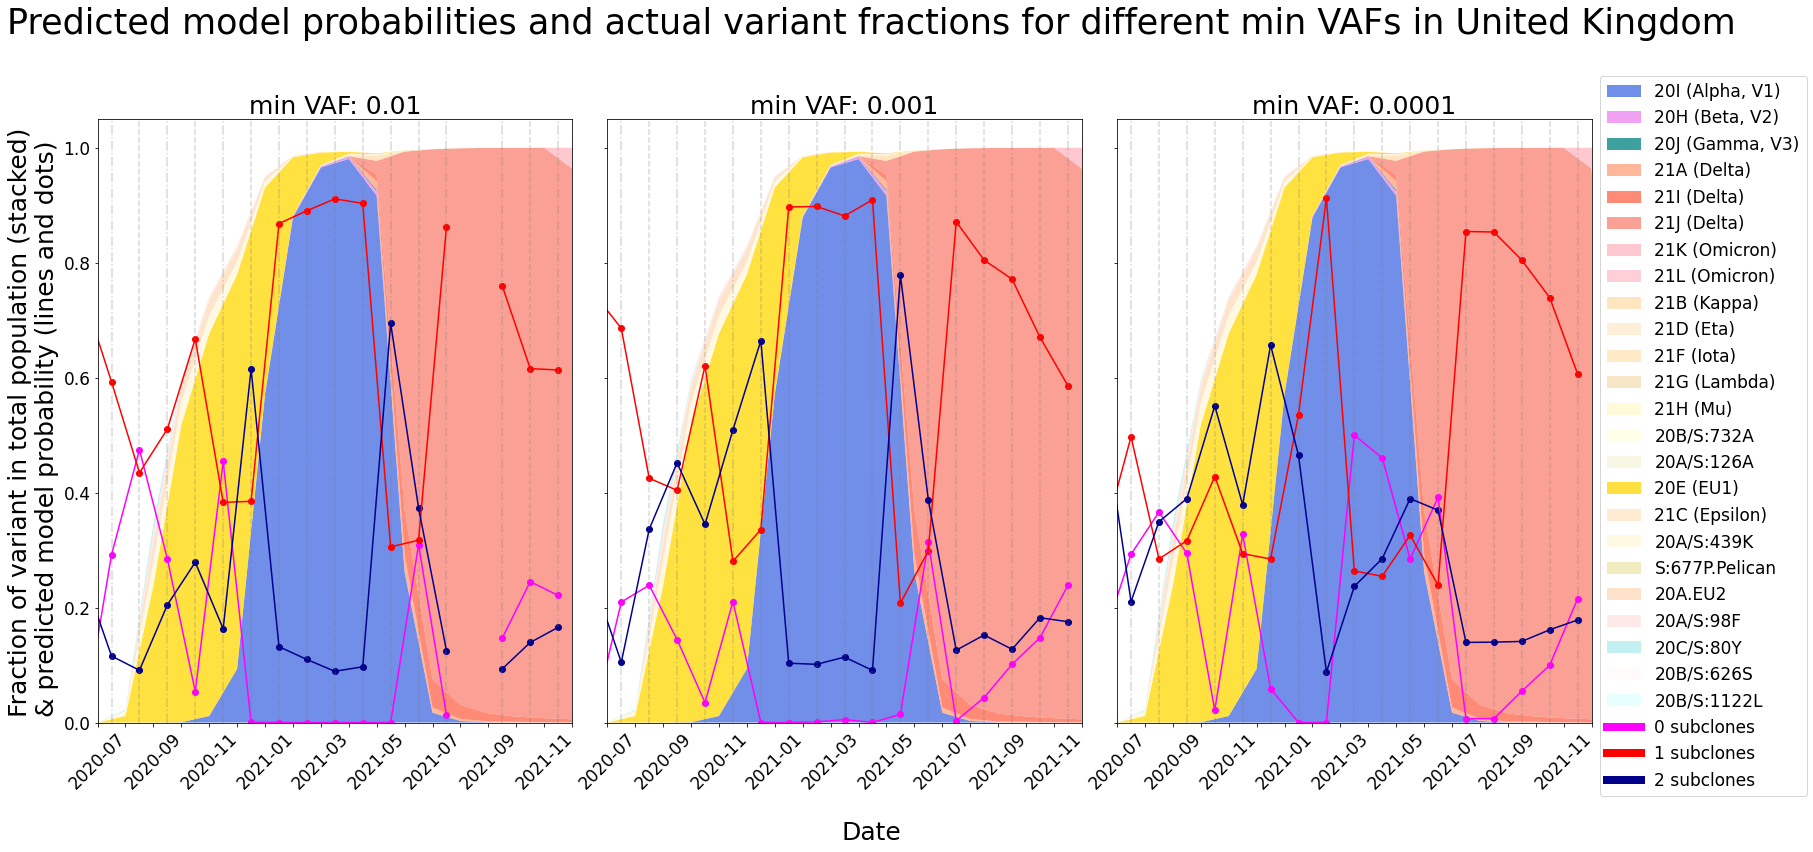

In [188]:
stack_and_line_plot_vary_filtering(cases, data, "United-Kingdom", [0.01, 0.001, 0.0001], gaps = True, vertical_lines=True, save = False)

In [28]:
plt.rc('font', size= 17)
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22) 

In [22]:
useful_countries = ["United-Kingdom", "Slovakia", "Mexico", "USA"]#["Bangladesh", "Slovakia", "Mexico", "USA", "United-Kingdom", "Bahrain", "New-Zealand", "Egypt", "Japan", "Austria", "Djibouti", "India"]

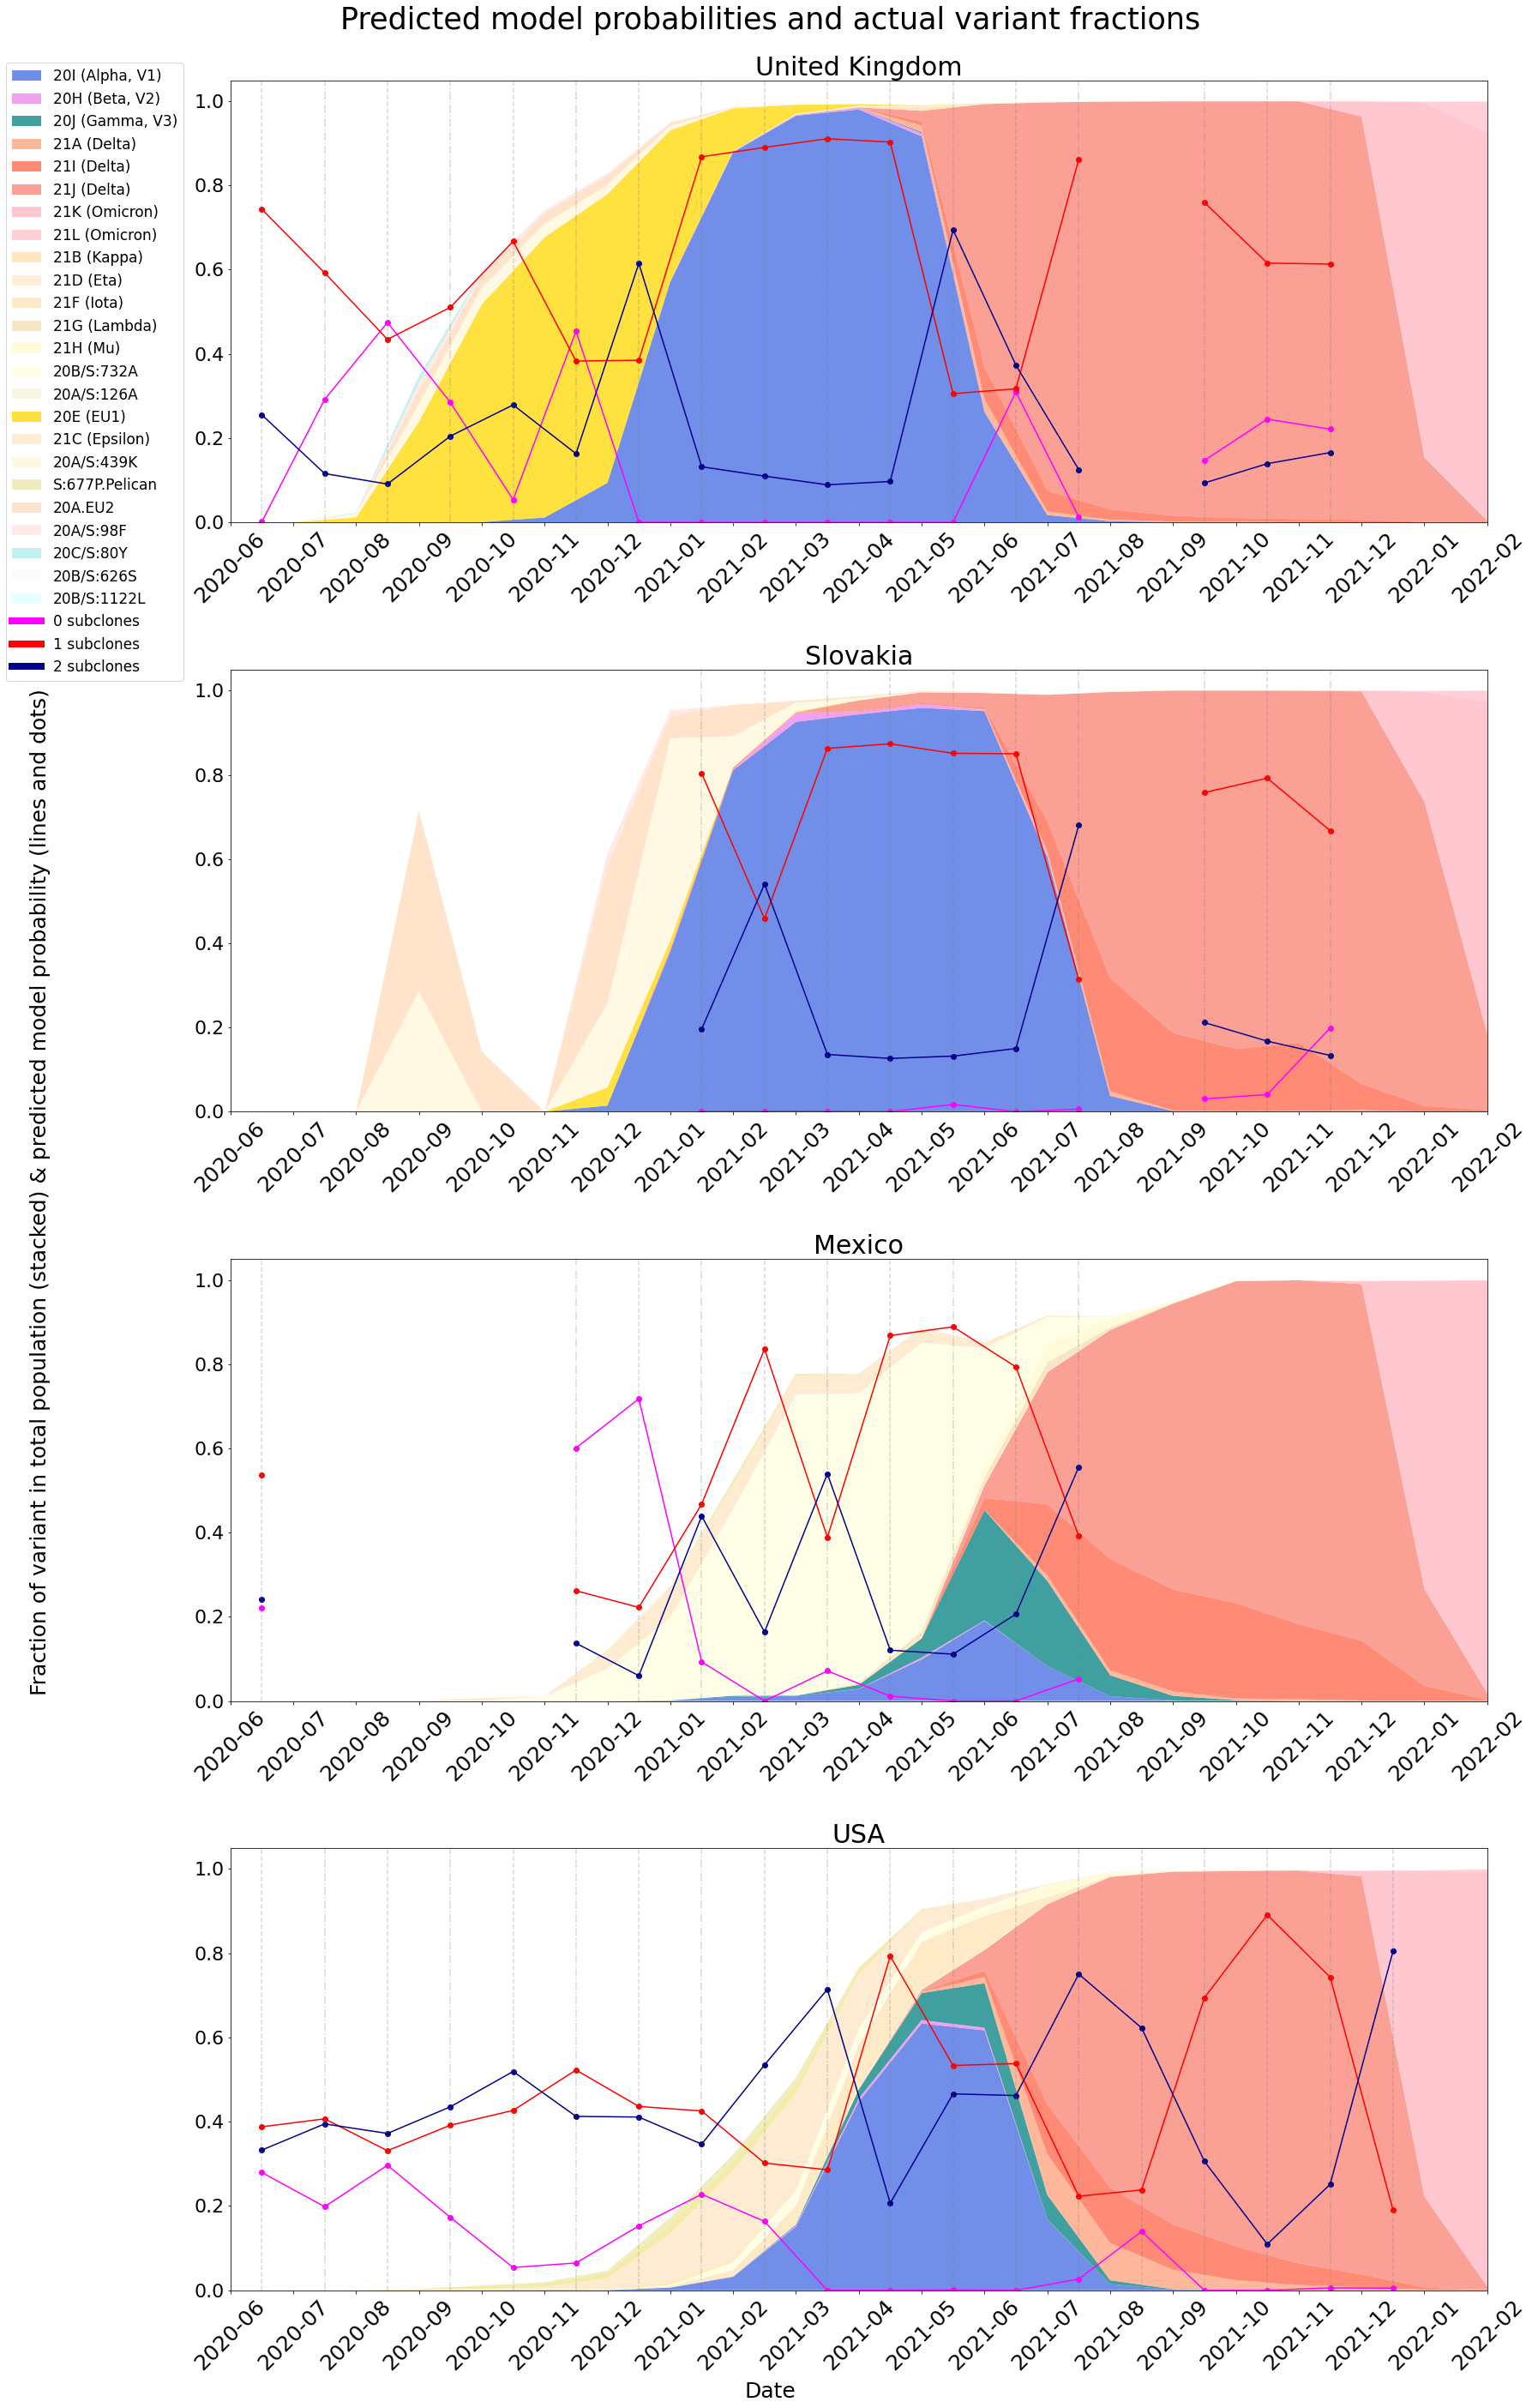

In [34]:
stack_and_line_plot(cases, data, useful_countries, 0.01, gaps = True, vertical_lines=True, save = False)

---
Predictions

In [35]:
parameter_files_01 = [
    # UK
    "m_United-Kingdom_2020-6_4774_115-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-7_2157_154-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-8_5185_223-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-9_9567_233-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-10_16288_200-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-11_20799_237-filtered0.01_Nmax2000",
    "m_United-Kingdom_2020-12_20282_141-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-1_42335_150-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-2_19586_150-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-3_722_187-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-4_1090_231-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-5_3445_240-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-6_4438_131-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-7_6862_101-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-9_4463_115-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-10_4817_151-filtered0.01_Nmax2000",
    "m_United-Kingdom_2021-11_3674_167-filtered0.01_Nmax2000",
    # USA
    "m_USA_2020-8_2478_163-filtered0.01_Nmax2000",
    "m_USA_2020-9_2126_176-filtered0.01_Nmax2000",
    "m_USA_2020-10_2605_187-filtered0.01_Nmax2000",
    "m_USA_2020-11_5307_189-filtered0.01_Nmax2000",
    "m_USA_2020-12_10731_200-filtered0.01_Nmax2000",
    "m_USA_2021-1_15431_237-filtered0.01_Nmax2000",
    "m_USA_2021-2_20513_274-filtered0.01_Nmax2000",
    "m_USA_2021-3_44445_267-filtered0.01_Nmax2000",
    "m_USA_2021-4_66036_273-filtered0.01_Nmax2000",
    "m_USA_2021-5_32416_270-filtered0.01_Nmax2000",
    "m_USA_2021-6_12436_307-filtered0.01_Nmax2000",
    "m_USA_2021-7_8715_295-filtered0.01_Nmax2000",
    "m_USA_2021-8_3767_275-filtered0.01_Nmax2000",
    "m_USA_2021-9_5055_216-filtered0.01_Nmax2000",
    "m_USA_2021-10_6004_189-filtered0.01_Nmax2000",
    "m_USA_2021-11_89440_160-filtered0.01_Nmax2000",
    "m_USA_2021-12_82879_257-filtered0.01_Nmax2000"
]

In [37]:
def get_inferred_parameters_2(name, n_clones):
    params_template_path = base_path + r"\{0}\finalpopulation\posterior\{0}-parameters-clone{1}.csv"
    path = params_template_path.format(name, n_clones)
    param_table = pd.read_csv(path)
    data = {c:param_table[c].median() for c in param_table.columns}
    data["μ"] = float(data.pop("mu"))
    data["clonalmutations"] = math.ceil(data["clonalmutations"])
    data["nclones"] = int(n_clones)
    if n_clones == 1:
        data["s"] = [float(data["s"])]
        data["tevent"] = [float(data.pop("t"))]
        del data["scmuts"]
    if n_clones == 2:
        data["s"] = [float(data.pop("s1")), float(data.pop("s2"))]
        data["tevent"] = [float(data.pop("t1")), float(data.pop("t2"))]
        data["frequency"] = [float(data.pop("frequency1")), float(data.pop("frequency2"))]
        del data["scmuts1"]
        del data["scmuts2"]
    del data["weight"]
    del data["cellularity"]
    return data

In [38]:
def get_parameters(dictionary, name):
    _, country, date, read_depth, n_mutations, _, _ = ("-".join(name.split("-")[:-1]) + "_" + name.split("-")[-1]).split("_")
    year, month = list(map(lambda x:int(x), date.split("-")))
    if country not in dictionary:
        dictionary[country] = dict()
    date_key = f"{year}-{month:02d}"
    # find which model to use (0,1,2 subclones)
    n_clones = cu.find_which_model(name)
    # there's nothing interesting with no subclones
    if (n_clones == 0):
        return dictionary
    # read parameters
    parameters = get_inferred_parameters_2(name, n_clones)
    dictionary[country][date_key] = parameters
    return dictionary

In [39]:
parameter_data_01 = reduce(get_parameters, parameter_files_01, dict())

In [45]:
def single_plot(ax, country_freqs, parameter_data, country, date, vertical_lines = False, stacked = False, indices = None):
    country_data = parameter_data[country][date]
    b = 3
    if country_data["nclones"] == 2:
        x = np.linspace(0, 10, 1000)
        f = lambda i:cu.calculate_frequency_2(
            country_data['s'][0], 
            country_data['s'][1], 
            country_data['tevent'][0], 
            country_data['tevent'][1], 
            np.log(b), 
            i
        )
        y = np.array([f(i) for i in x])
    elif country_data["nclones"] == 1:
        x = np.linspace(0, 30, 1000)
        f = lambda i:cu.calculate_frequency_1(
            country_data['s'][0], 
            country_data['tevent'][0], 
            np.log(b), 
            i
        )
        y = np.array([f(i) for i in x])
        x /= b
    else:
        return
    freqs = (lambda fr:([fr] if type(fr) == np.float64 or type(fr) == float else fr))(country_data["frequency"])
    x_min = x[np.argmin(np.abs(y[:,1] - freqs[0])) if len(freqs) == 2 else np.argmin(np.abs(y - np.array(freqs)))]
    dx = label_positions[date] + 0.5 - x_min
    x += dx
    handles = []
    if country_data["nclones"] == 2:
        handles.append([
            ax.plot(x, y[:,1], color="black", label="subclone 1")[0],
            ax.plot(x, y[:,0], color="gray", label="subclone 2")[0]])
    else:
        handles.append([ax.plot(x, y, color="black", label="subclone")[0]])
    for i,fr in enumerate(freqs):
        ax.scatter([label_positions[date] + 0.5], fr, color=["black", "gray"][i])
    
    if vertical_lines:
        for i in np.arange(len(labels)):
            ax.axvline(i, color="gray", linestyle=["--", "-."][i%2], alpha=0.1)
    
    handles.append(plot_variant_fraction(country_freqs, ax, stacked, indices = indices))
    ax.set_title(f"{date}")
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    return handles

def plot_variant_fractions_and_predictions(cases, parameter_data, country, date, vertical_lines = False, stacked = False, title = None, important = False, save = False):
    country_freqs = cu.get_freqs(cases, country)
    plt.rc('font', size=17) # default 10
    handles = []
    date = list(filter(lambda d:d in parameter_data[country], date))
    n = len(date)
    if n == 0:
        return
    columns = 2
    rows = (n+columns-1)//columns
    fig, axes = plt.subplots(rows, columns, figsize=(25, 5.7*rows), sharex=True, sharey=True)#, dpi=200) , constrained_layout = True
    if rows == 1:
        axes = [axes]
    all_figures.add(fig)
    for i,d in enumerate(date):
        if d not in parameter_data[country]:
            continue
        handles.extend(single_plot(axes[i//columns][i%columns], country_freqs, parameter_data, country, d, vertical_lines, stacked, [0,5,6,15] if important else None))
    
    handles = sorted(handles, key=lambda x:len(x))
    legend = fig.legend(handles = handles[-1] + list(filter(lambda h:len(h) == 2, handles))[0], loc="upper left", bbox_to_anchor=(0, 0.96))
    for line in legend.get_lines():
        line.set_linewidth(8)
    fig.suptitle(title, fontsize=32)
    fig.supxlabel("Date", fontsize = 25)
    fig.supylabel("Fraction of variant in total population", fontsize = 25)
    fig.tight_layout(h_pad=1.5)
    fig.subplots_adjust(top=0.95, left = 0.13)
    if save:
        fig.savefig(fig_path.format("fraction_predictions_uk.eps"))

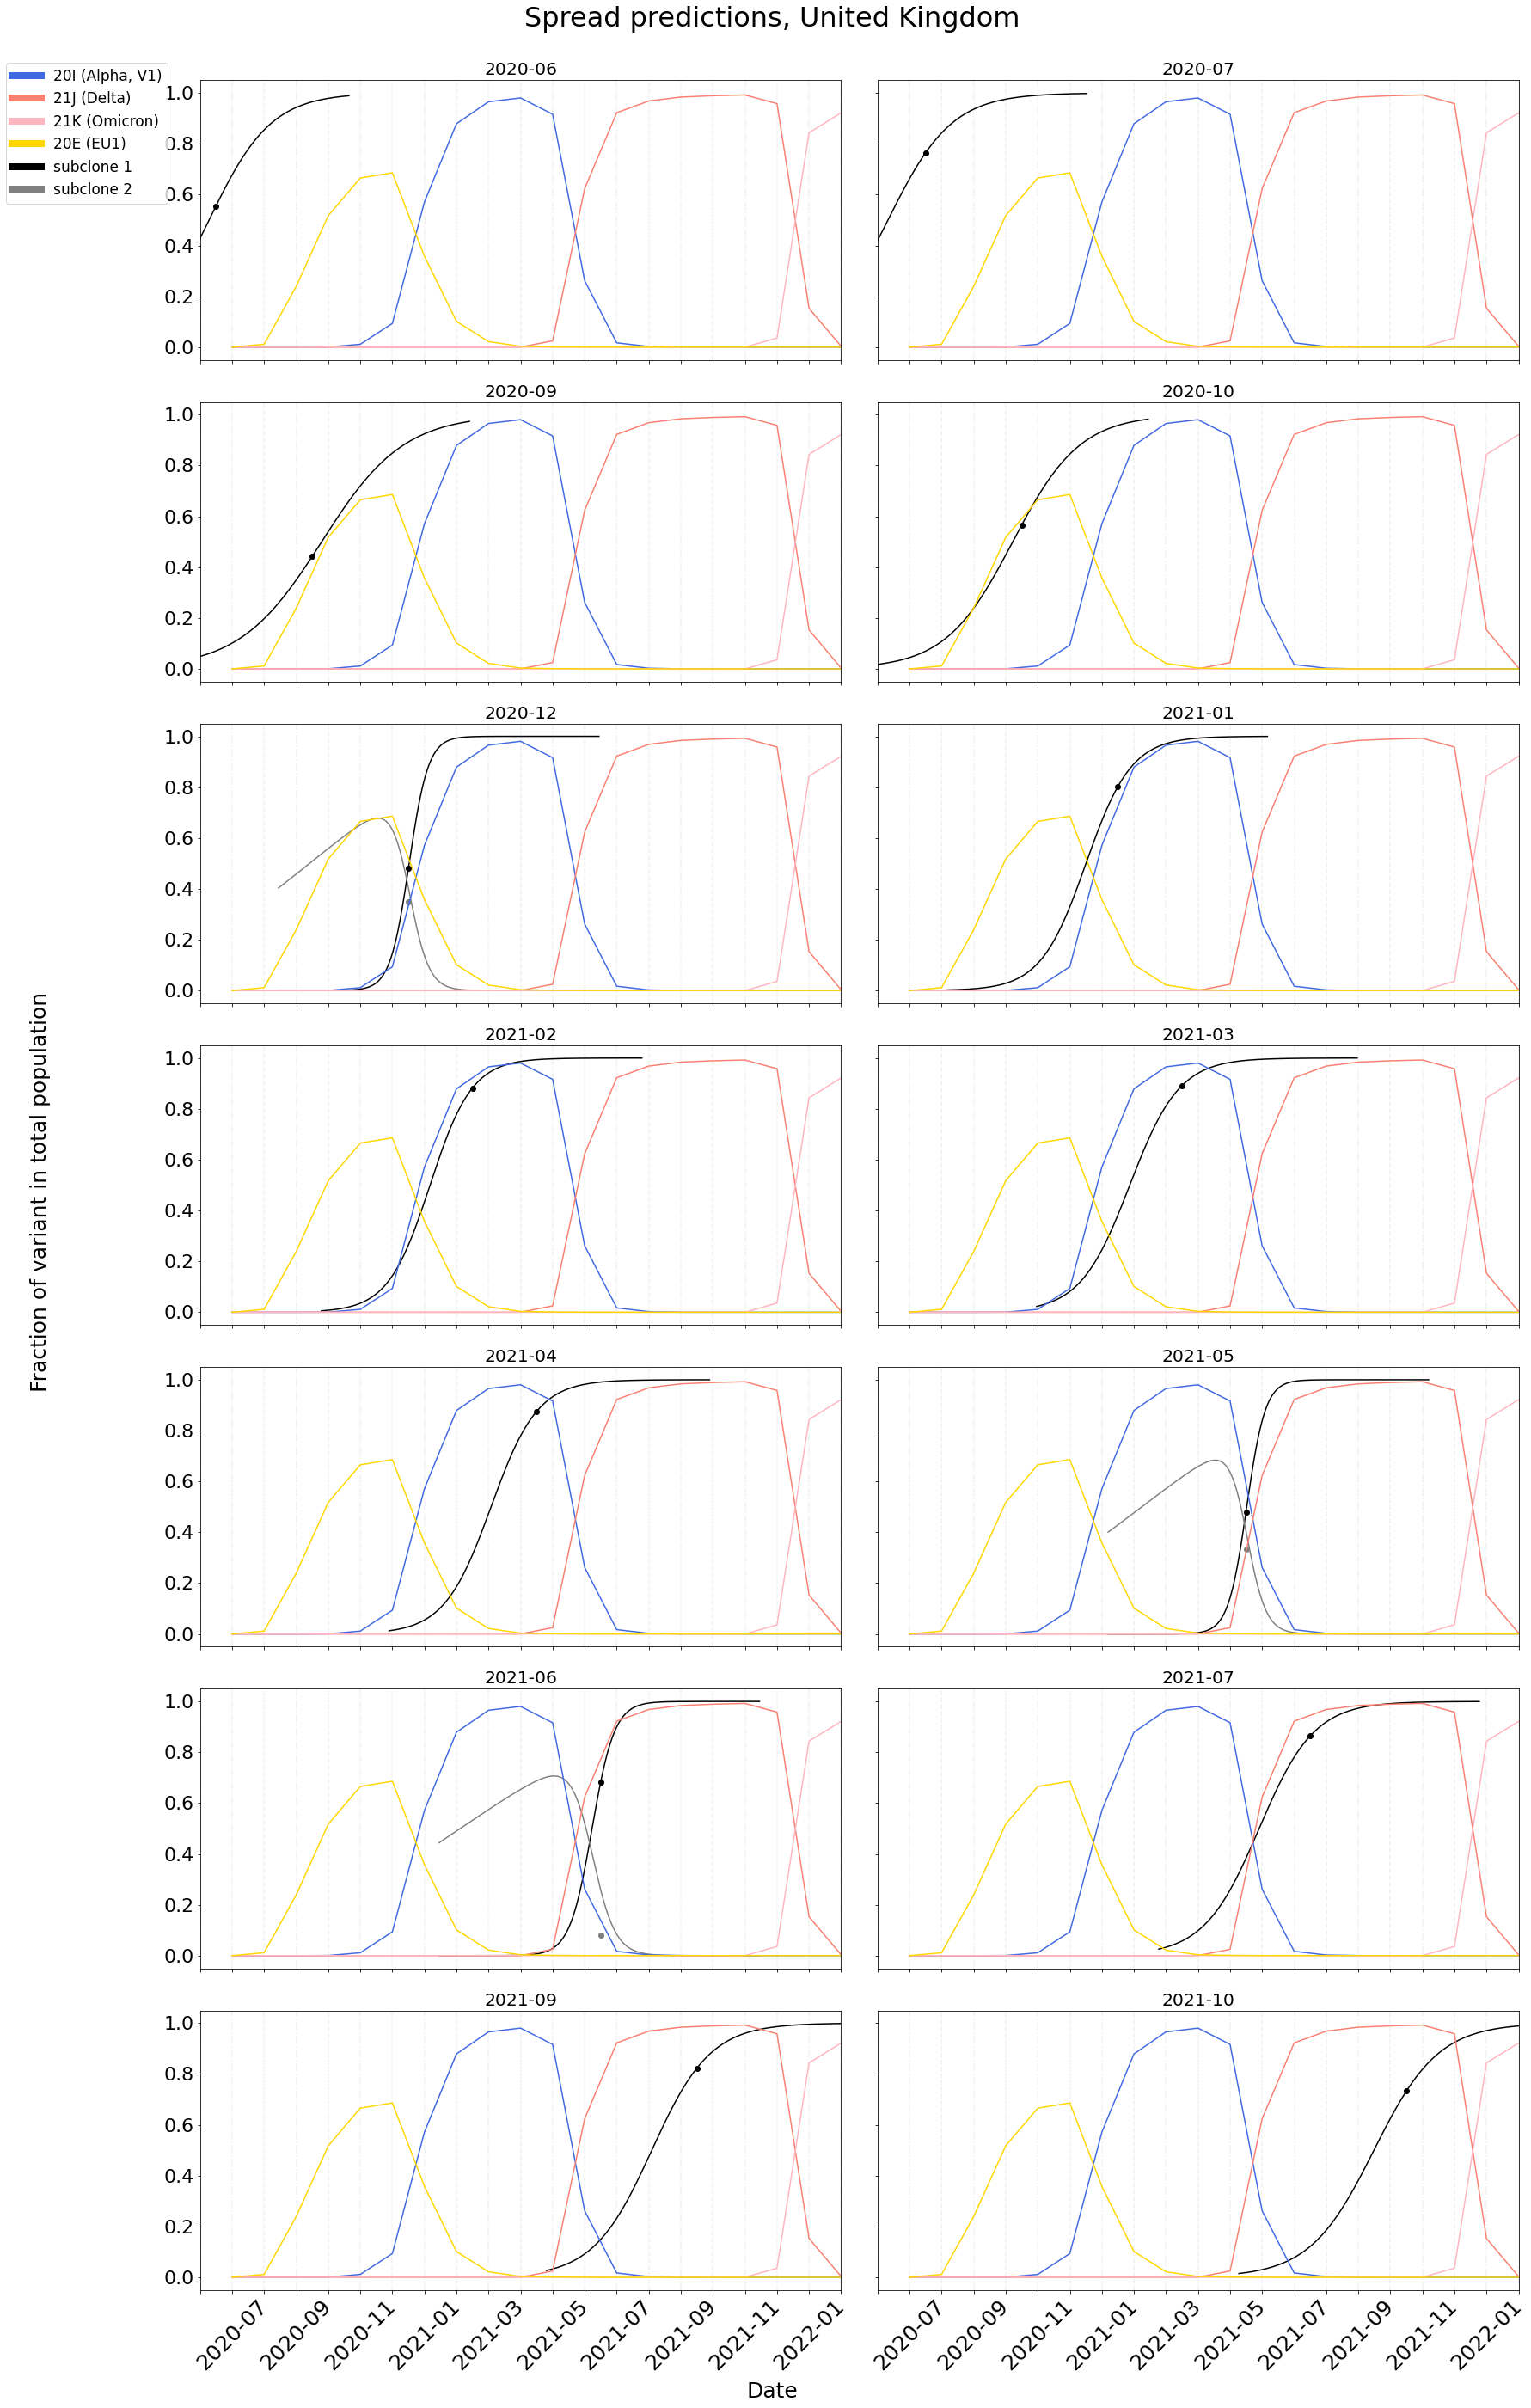

In [46]:
plot_variant_fractions_and_predictions(cases, parameter_data_01, "United-Kingdom",
                                       [f"2020-{i:02d}" for i in range(6, 13)] + [f"2021-{i:02d}" for i in range(1, 11)], True, 
                                       title="Spread predictions, United Kingdom", important = True)

---
**Inferred parameters**

Don't differ much for different birth rates

In [47]:
# United Kingdom
inferred_params_files = list(map(lambda x:[x[0], x[0]+f"_b-log({x[1]})", cu.find_which_model(x[0])], [
    # alpha
    ["m_United-Kingdom_2021-1_42335_150-filtered0.01_Nmax2000",4.5],
    ["m_United-Kingdom_2021-2_19586_150-filtered0.01_Nmax2000",4.5],
    ["m_United-Kingdom_2021-3_722_187-filtered0.01_Nmax2000",4.5],
    ["m_United-Kingdom_2021-4_1090_231-filtered0.01_Nmax2000",4.5],
    # delta
    ["m_United-Kingdom_2021-5_3445_240-filtered0.01_Nmax2000",7.0],
    ["m_United-Kingdom_2021-6_4438_131-filtered0.01_Nmax2000",7.0],
    ["m_United-Kingdom_2021-7_6862_101-filtered0.01_Nmax2000",7.0],
    ["m_United-Kingdom_2021-9_4463_115-filtered0.01_Nmax2000",7.0],
    ["m_United-Kingdom_2021-10_4817_151-filtered0.01_Nmax2000",7.0],
    ["m_United-Kingdom_2021-11_3674_167-filtered0.01_Nmax2000",7.0],
]))

In [48]:
inferred_parameter_data = dict()
box_labels = set()
difs_medians = dict() # [0,1,2,4,6,8]
difs_avg = dict()
for x in inferred_params_files:
    p1 = cu.get_inferred_parameters(x[0], x[2])
    p2 = cu.get_inferred_parameters(x[1], x[2])
    medians = {k: p1[k][1]/p2[k][1] for k in p1.keys()}
    for k,v in medians.items():
        if k in difs_medians:
            difs_medians[k].append(v)
        else:
            difs_medians[k] = [v]
    averages = {k: p1[k][0]/p2[k][0] for k in p1.keys()}
    for k,v in averages.items():
        if k in difs_avg:
            difs_avg[k].append(v)
        else:
            difs_avg[k] = [v]
    if len(box_labels) == 0 or len(box_labels) < len(list(p1.keys())):
        box_labels.update(set(p1.keys()))
box_labels = sorted(list(box_labels))
box_labels = box_labels[1:5] + [box_labels[0]] + box_labels[5:]

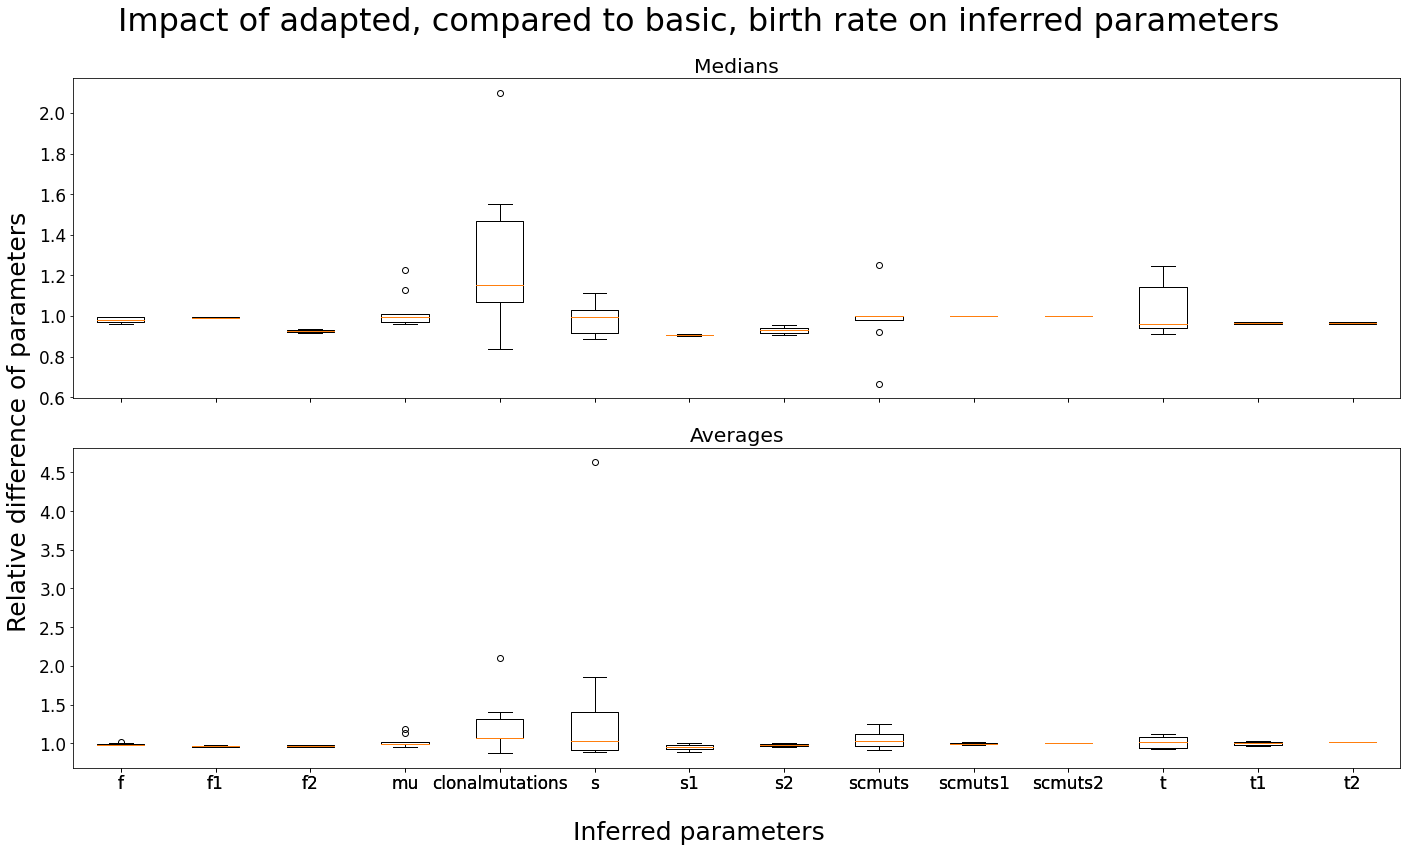

In [574]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex = True)
_ = ax1.boxplot([difs_medians[k] for k in box_labels], labels = list(map(lambda x:x.replace("frequency", "f"), box_labels)))
ax1.set_title("Medians")
_ = ax2.boxplot([difs_avg[k] for k in box_labels], labels = list(map(lambda x:x.replace("frequency", "f"), box_labels)))
ax2.set_title("Averages")
fig.suptitle('Impact of adapted, compared to basic, birth rate on inferred parameters', fontsize=32)
fig.supxlabel("Inferred parameters", fontsize = 25)
fig.supylabel("Relative difference of parameters", fontsize = 25)
fig.tight_layout()
fig.savefig(fig_path.format("parameter_relative_variable_birthrate.eps"))

Differ across countries for same variant

In [49]:
param_comp_data = {
    "UK": {
        "alpha": [
            "m_United-Kingdom_2020-12_20282_141-filtered0.01_Nmax2000",
            "m_United-Kingdom_2021-1_42335_150-filtered0.01_Nmax2000",
            "m_United-Kingdom_2021-2_19586_150-filtered0.01_Nmax2000",
            "m_United-Kingdom_2021-3_722_187-filtered0.01_Nmax2000",
            "m_United-Kingdom_2021-4_1090_231-filtered0.01_Nmax2000"
        ],
        "delta": [
            "m_United-Kingdom_2021-5_3445_240-filtered0.01_Nmax2000",
            "m_United-Kingdom_2021-6_4438_131-filtered0.01_Nmax2000",
            "m_United-Kingdom_2021-7_6862_101-filtered0.01_Nmax2000",
            "m_United-Kingdom_2021-9_4463_115-filtered0.01_Nmax2000",
            "m_United-Kingdom_2021-10_4817_151-filtered0.01_Nmax2000",
            "m_United-Kingdom_2021-11_3674_167-filtered0.01_Nmax2000"
        ]
    },
    "USA": {
        "alpha": [
            "m_USA_2021-3_44445_267-filtered0.01_Nmax2000",
            "m_USA_2021-4_66036_273-filtered0.01_Nmax2000",
            "m_USA_2021-5_32416_270-filtered0.01_Nmax2000",
            "m_USA_2021-6_12436_307-filtered0.01_Nmax2000"
        ],
        "delta": [
            "m_USA_2021-7_8715_295-filtered0.01_Nmax2000",
            "m_USA_2021-8_3767_275-filtered0.01_Nmax2000",
            "m_USA_2021-9_5055_216-filtered0.01_Nmax2000",
            "m_USA_2021-10_6004_189-filtered0.01_Nmax2000",
            "m_USA_2021-11_89440_160-filtered0.01_Nmax2000"
        ]
    }
}

In [50]:
compared_data = dict()
p_box_labels = set()
for country,v in param_comp_data.items():
    compared_data[country] = dict()
    for variant, files in v.items():
        variant_data = dict()
        for file in files:
            nclones = cu.find_which_model(file)
            params = cu.get_inferred_parameters(file, nclones)
            for key, (av, med) in params.items():
                if key in variant_data:
                    variant_data[key]["median"].append(med)
                    variant_data[key]["average"].append(av)
                else:
                    variant_data[key] = {
                        "median": [med],
                        "average": [av]
                    }
        for key in variant_data.keys():
            variant_data[key]["median"] = np.mean(variant_data[key]["median"])
            variant_data[key]["average"] = np.median(variant_data[key]["average"])
        compared_data[country][variant] = variant_data
        if len(p_box_labels) == 0 or len(p_box_labels) < len(list(variant_data.keys())):
            p_box_labels.update(set(variant_data.keys()))
        
p_box_labels = sorted(list(p_box_labels))
p_box_labels = p_box_labels[1:5] + [p_box_labels[0]] + p_box_labels[5:]

In [591]:
pp(compared_data)

{'UK': {'alpha': {'clonalmutations': {'average': 75.74691805964868,
                                      'median': 85.5804132457063},
                  'frequency': {'average': 0.876067806197607,
                                'median': 0.8628125},
                  'frequency1': {'average': 0.4801080139372822,
                                 'median': 0.481},
                  'frequency2': {'average': 0.3229808362369338,
                                 'median': 0.3485},
                  'mu': {'average': 1.4793330219511747,
                         'median': 1.4453340494393978},
                  's': {'average': 0.48703269328344534,
                        'median': 0.42412331619873933},
                  's1': {'average': 0.4039446498267825,
                         'median': 0.3683522945482915},
                  's2': {'average': 0.2958305892740322,
                         'median': 0.2604022358760434},
                  'scmuts': {'average': 6.868857236723577, 'median': 7

In [602]:
uk_alpha_medians, uk_alpha_avgs = np.array(list(zip(*[(v["median"],v["average"]) for (k,v) in sorted(compared_data["UK"]["alpha"].items(), key = lambda x:x[0])])))
us_alpha_medians, us_alpha_avgs = np.array(list(zip(*[(v["median"],v["average"]) for (k,v) in sorted(compared_data["USA"]["alpha"].items(), key = lambda x:x[0])])))

uk_delta_medians, uk_delta_avgs = np.array(list(zip(*[(v["median"],v["average"]) for (k,v) in sorted(compared_data["UK"]["delta"].items(), key = lambda x:x[0])])))
us_delta_medians, us_delta_avgs = np.array(list(zip(*[(v["median"],v["average"]) for (k,v) in sorted(compared_data["USA"]["delta"].items(), key = lambda x:x[0])])))

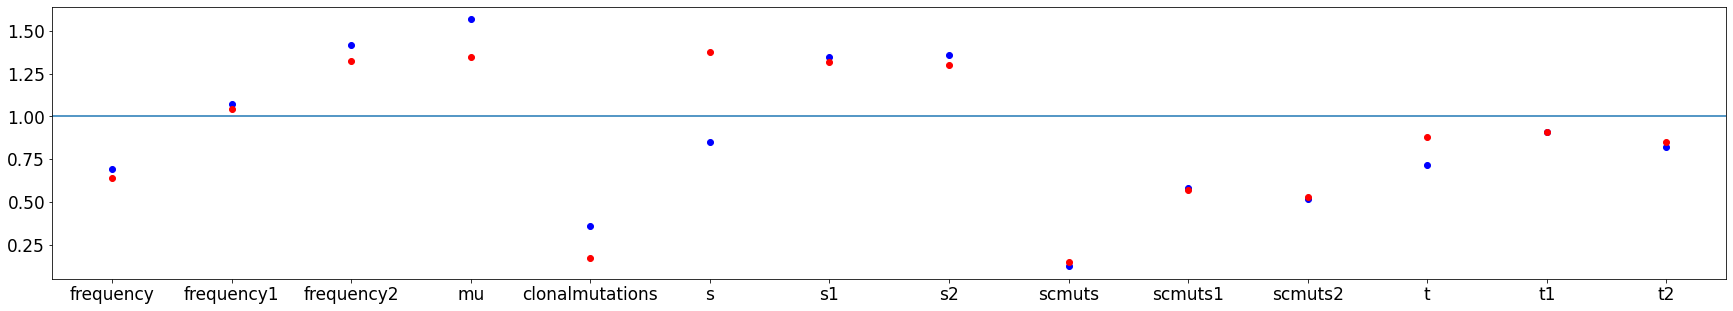

In [627]:
fig, ax = plt.subplots(figsize=(30,5))
ax.scatter(np.arange(len(p_box_labels)), uk_delta_medians / us_delta_medians, color="b")
ax.scatter(np.arange(len(p_box_labels)), uk_delta_avgs / us_delta_avgs, color="r")
ax.set_xticks(np.arange(len(p_box_labels)))
ax.set_xticklabels(p_box_labels)
ax.plot([-1,14], [1,1])
ax.set_xlim(-0.5, 13.5)
print()

In [51]:
compared_data = dict()
for country,v in param_comp_data.items():
    compared_data[country] = dict()
    for variant, files in v.items():
        variant_data = dict()
        for file in files:
            nclones = cu.find_which_model(file)
            params = cu.get_inferred_parameters(file, nclones)
            for key, (av, med) in params.items():
                if key in variant_data:
                    variant_data[key]["median"].append(med)
                    variant_data[key]["average"].append(av)
                else:
                    variant_data[key] = {
                        "median": [med],
                        "average": [av]
                    }
        compared_data[country][variant] = variant_data

In [52]:
uk_alpha_medians, uk_alpha_avgs = list(zip(*[(v["median"],v["average"]) for (k,v) in sorted(compared_data["UK"]["alpha"].items(), key = lambda x:x[0])]))
us_alpha_medians, us_alpha_avgs = list(zip(*[(v["median"],v["average"]) for (k,v) in sorted(compared_data["USA"]["alpha"].items(), key = lambda x:x[0])]))

uk_delta_medians, uk_delta_avgs = list(zip(*[(v["median"],v["average"]) for (k,v) in sorted(compared_data["UK"]["delta"].items(), key = lambda x:x[0])]))
us_delta_medians, us_delta_avgs = list(zip(*[(v["median"],v["average"]) for (k,v) in sorted(compared_data["USA"]["delta"].items(), key = lambda x:x[0])]))

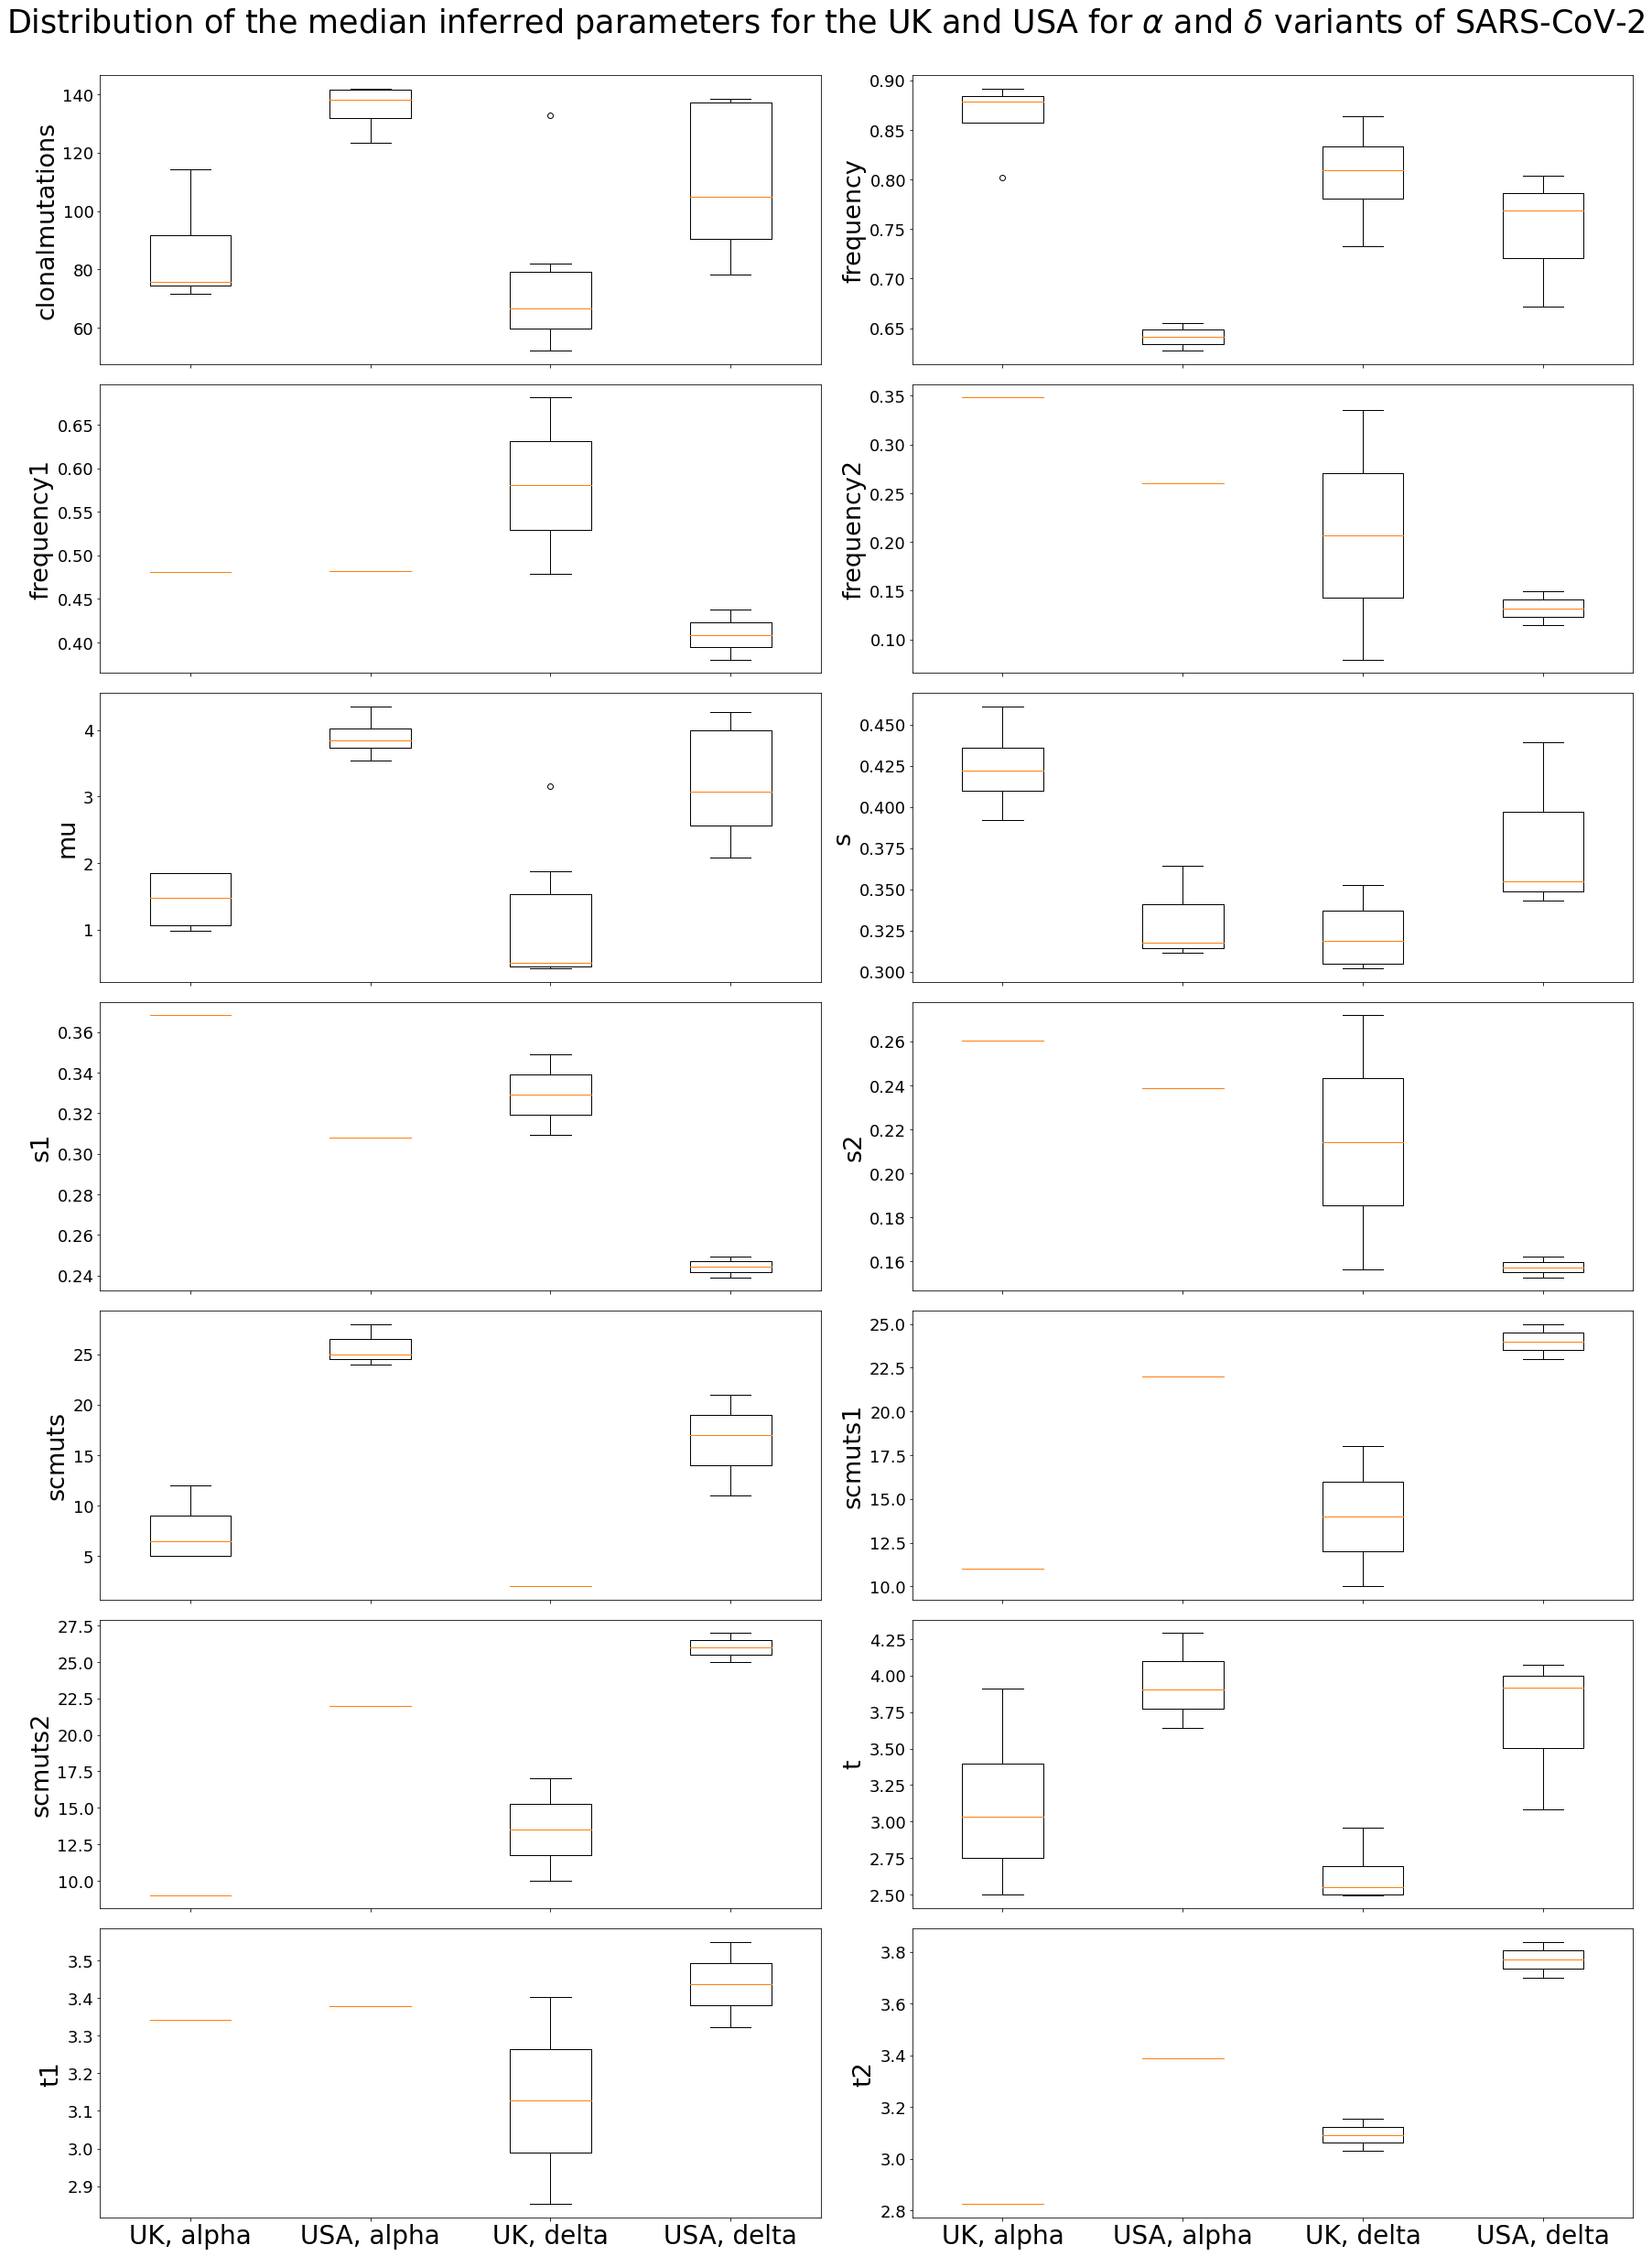

In [65]:
plt.rc('font', size= 17)
#plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=18) 
fig, axes = plt.subplots(7,2, figsize=(25,35), sharex=True)
p_box_labels = sorted(list(p_box_labels))
for i, (axl, axr) in enumerate(axes):
    axl.boxplot([uk_alpha_medians[i*2], us_alpha_medians[i*2], uk_delta_medians[i*2], us_delta_medians[i*2]])
    axl.set_ylabel(p_box_labels[i*2], fontsize = 27)
    axl.set_xticks([1,2,3,4])
    axl.set_xticklabels([f"{country}, {variant}" for variant in ["alpha", "delta"] for country in ["UK", "USA"]], fontsize=28)
    
    axr.boxplot([uk_alpha_medians[i*2+1], us_alpha_medians[i*2+1], uk_delta_medians[i*2+1], us_delta_medians[i*2+1]])
    axr.set_ylabel(p_box_labels[i*2+1], fontsize = 27)
    axr.set_xticks([1,2,3,4])
    axr.set_xticklabels([f"{country}, {variant}" for variant in ["alpha", "delta"] for country in ["UK", "USA"]], fontsize=28)
    
fig.suptitle(r'Distribution of the median inferred parameters for the UK and USA for $\alpha$ and $\delta$ variants of SARS-CoV-2', fontsize = 35)
fig.tight_layout(h_pad=1, w_pad=0.7)
fig.subplots_adjust(top=0.95)
fig.savefig(fig_path.format("parameters_uk_usa_alpha_delta.eps"))

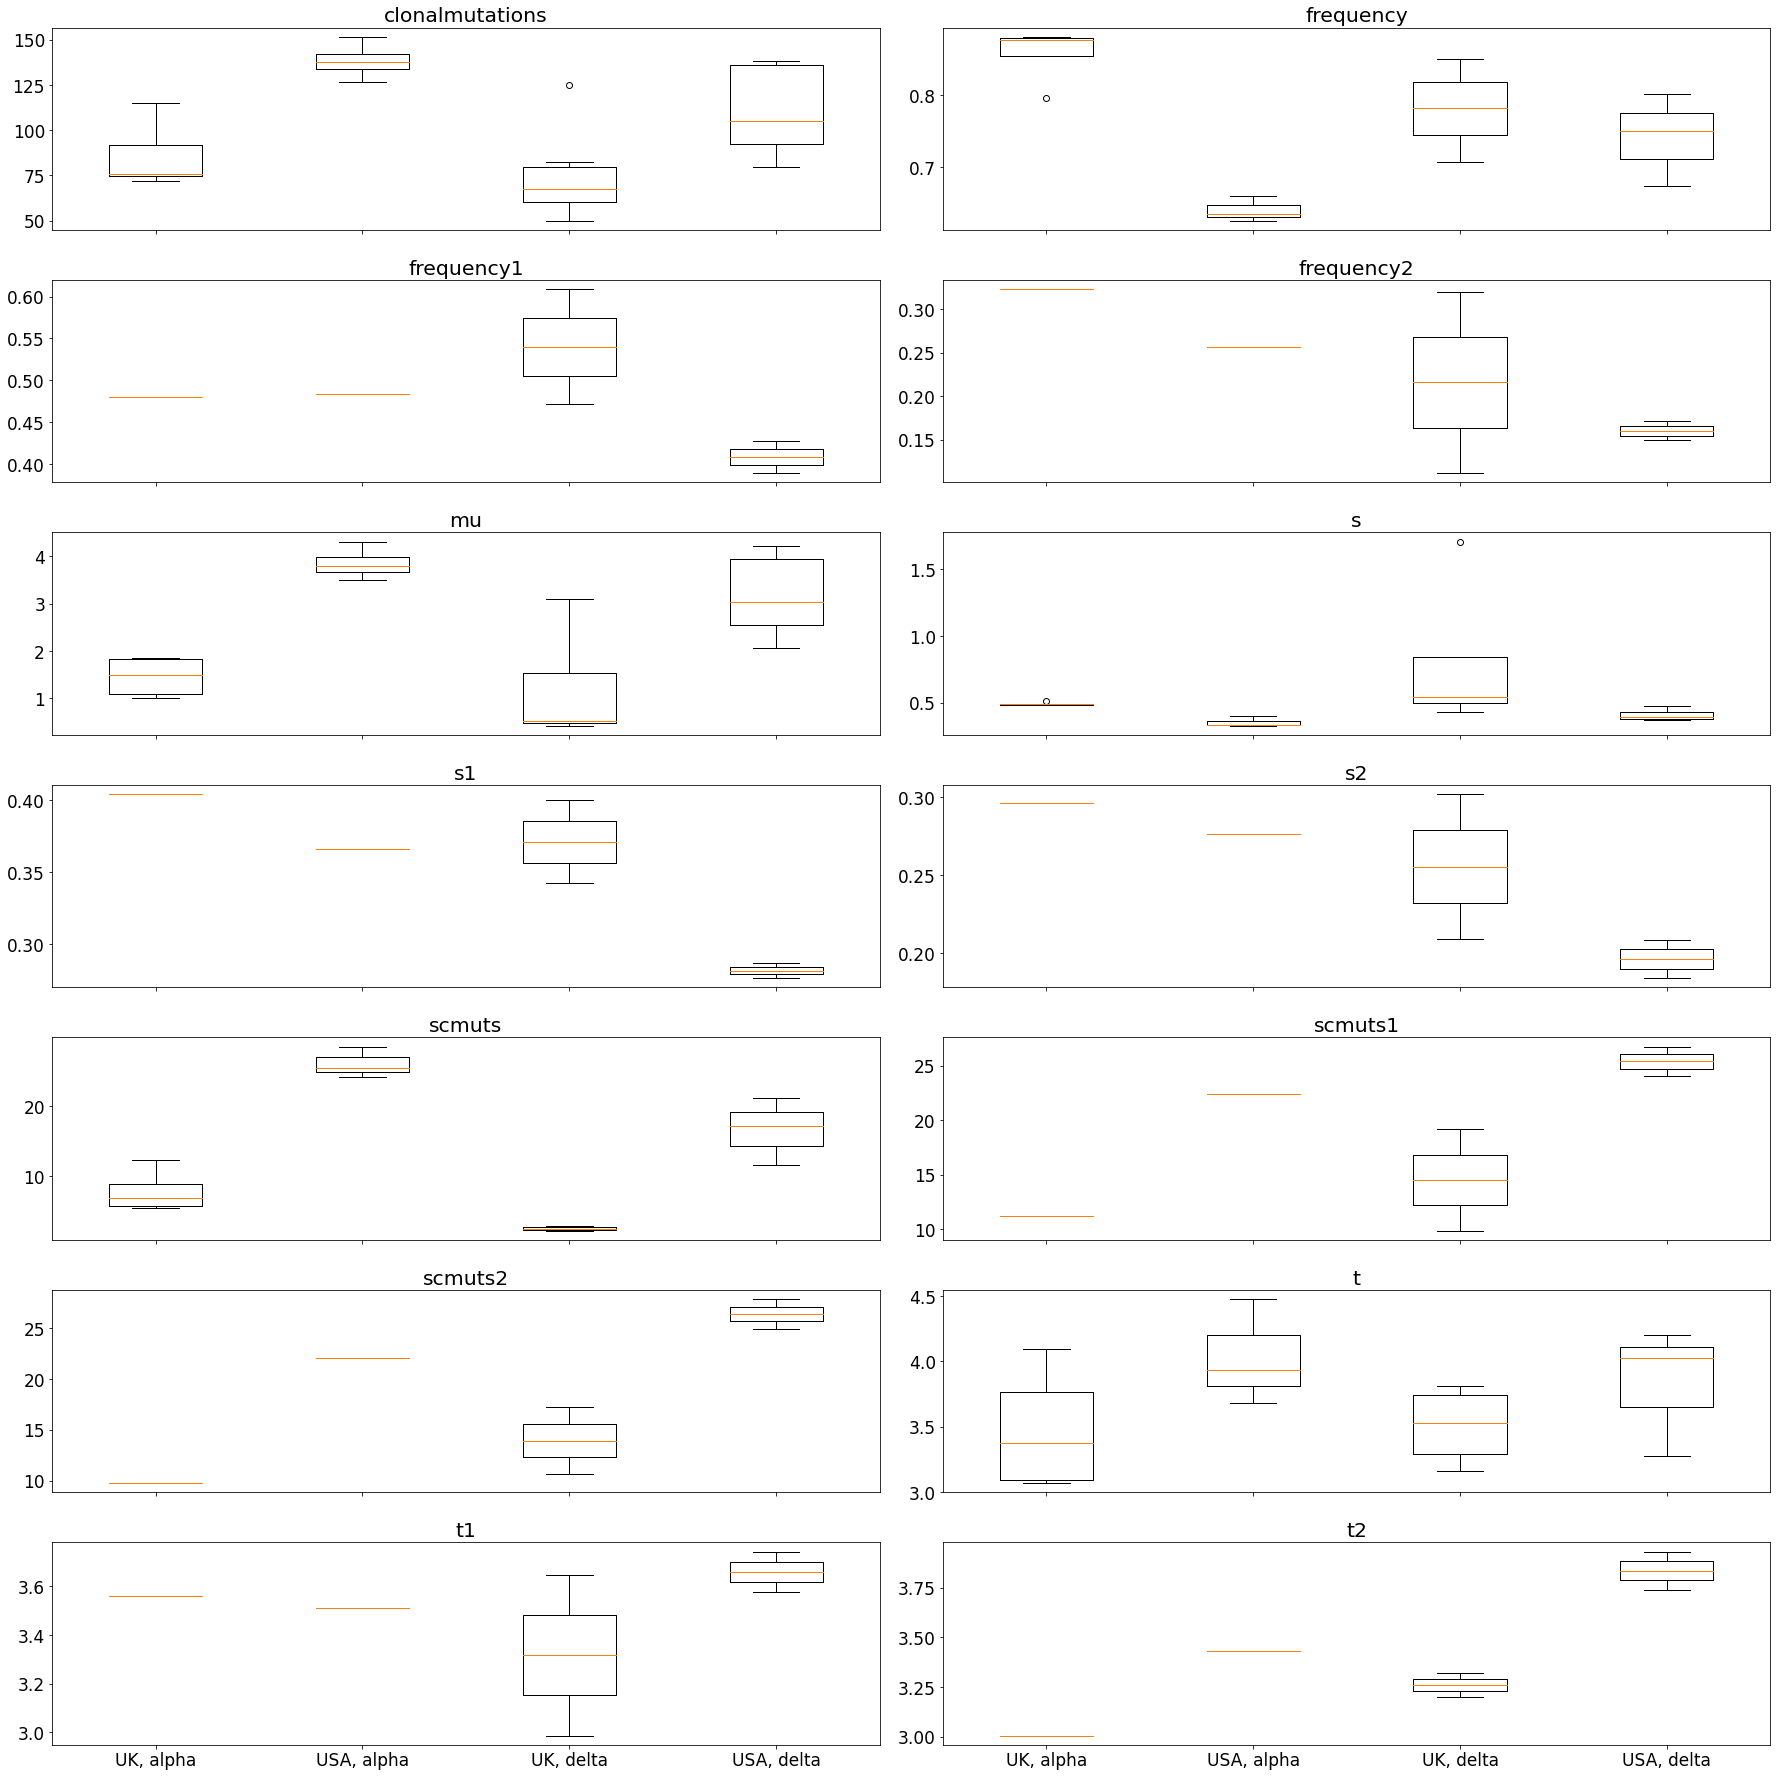

In [646]:
fig, axes = plt.subplots(7,2, figsize=(25,25), sharex=True)
p_box_labels = sorted(list(p_box_labels))
for i, (axl, axr) in enumerate(axes):
    axl.boxplot([uk_alpha_avgs[i*2], us_alpha_avgs[i*2], uk_delta_avgs[i*2], us_delta_avgs[i*2]])
    axr.boxplot([uk_alpha_avgs[i*2+1], us_alpha_avgs[i*2+1], uk_delta_avgs[i*2+1], us_delta_avgs[i*2+1]])
    axl.set_title(p_box_labels[i*2])
    axr.set_title(p_box_labels[i*2+1])
    axl.set_xticks([1,2,3,4])
    axr.set_xticks([1,2,3,4])
    axl.set_xticklabels([f"{country}, {variant}" for variant in ["alpha", "delta"] for country in ["UK", "USA"]])
    axr.set_xticklabels([f"{country}, {variant}" for variant in ["alpha", "delta"] for country in ["UK", "USA"]])
fig.tight_layout()

---
VAF histogram

In [31]:
with open(cu.COVID_PATH + r"\SubClonalSelection\example\oneclone.txt", "r") as f:
    vaf_distribution = np.array(list(map(lambda x:float(x.strip()), f.readlines())))

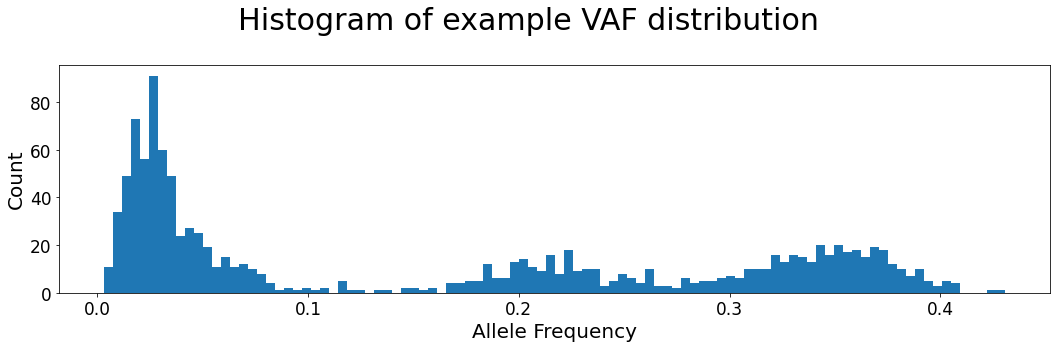

In [57]:
fig, ax = plt.subplots(figsize=(15,5))
plt.rc('font', size=17)
_ = ax.hist(vaf_distribution, bins=100)
ax.set_xlabel("Allele Frequency", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20)
fig.suptitle("Histogram of example VAF distribution", fontsize = 30)
fig.tight_layout(h_pad=1, w_pad=1)
fig.savefig(fig_path.format("example_vaf_histogram.eps"))